# Train

In [10]:
import numpy as np
import logging
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.loader import FactoryLoader
from utils.dl import DLPipeline
from utils.preprocessing import PreprocessingFactory

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}: {torch.cuda.get_device_name(0)}")

cuda: NVIDIA GeForce RTX 4050 Laptop GPU


In [12]:
# Dataset path
TRAIN_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\train"
VAL_PATH = r"C:\Users\gimes\Src\repos\CADx-Project\dataset\binary\val"

In [13]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# MODEL

In [19]:
class SkinLesionCNN(nn.Module):
    # input images are 224x224
    def __init__(self):
        super(SkinLesionCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=128*28*28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=1)  # Binary classification

    def forward(self, x):
        # Convolutional layers with ReLU and MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

# Instantiate the model
model = SkinLesionCNN()
print(model)

SkinLesionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


# PREPROCESSING

In [20]:
# Assuming you have a PreprocessMelanoma factory instance
factory = PreprocessingFactory()
factory.pad2square(fill=np.nan) # Pad images to form square shape, filling with 0
factory.resize((224, 224))
factory.normalize2float()

____
# TRAINING

In [34]:
# Create data loaders
PERCENT = 100
train_loader = FactoryLoader(TRAIN_PATH, batch_size=32, factory=factory, percentage=PERCENT, shuffle=PERCENT<20).get_loader()
val_loader = FactoryLoader(VAL_PATH, batch_size=32, factory=factory, percentage=PERCENT, shuffle=PERCENT<20).get_loader()

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

dl = DLPipeline(model, optimizer, criterion, train_loader, val_loader, "CustomCNN")

In [ ]:
dl.train(epochs=10)

[TRAIN] Epoch 1/10


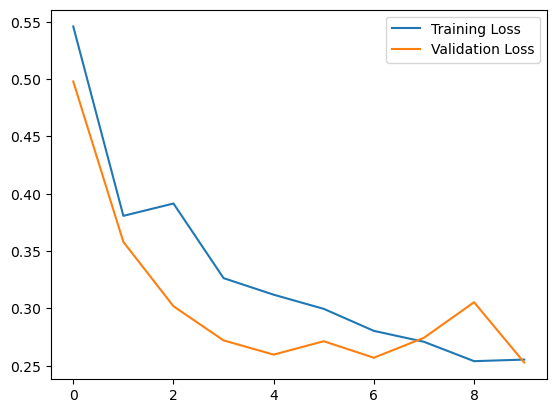

In [24]:
dl.plot_losses()

In [31]:
from sklearn.metrics import classification_report

def evaluate(dl: DLPipeline):
    dl.model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in dl.val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = dl.model(images)
            predicted = torch.round(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])
    return report

In [33]:
print(evaluate(dl))

              precision    recall  f1-score   support

     Class 0       0.94      0.85      0.89       189
     Class 1       0.86      0.94      0.90       189

    accuracy                           0.90       378
   macro avg       0.90      0.90      0.90       378
weighted avg       0.90      0.90      0.90       378

              precision    recall  f1-score   support

     Class 0       0.94      0.85      0.89       189
     Class 1       0.86      0.94      0.90       189

    accuracy                           0.90       378
   macro avg       0.90      0.90      0.90       378
weighted avg       0.90      0.90      0.90       378

